# Where should a drinks company run promotions?

## 📖 Background
Your company owns a chain of stores across Russia that sell a variety of alcoholic drinks. The company recently ran a wine promotion in Saint Petersburg that was very successful. Due to the cost to the business, it isn’t possible to run the promotion in all regions. The marketing team would like to target 10 other regions that have similar buying habits to Saint Petersburg where they would expect the promotion to be similarly successful.

### The data
The marketing team has sourced you with historical sales volumes per capita for several different drinks types.

- "year" - year (1998-2016)
- "region" - name of a federal subject of Russia. It could be oblast, republic, krai, autonomous okrug, federal city and a single autonomous oblast
- "wine" - sale of wine in litres by year per capita
- "beer" - sale of beer in litres by year per capita
- "vodka" - sale of vodka in litres by year per capita
- "champagne" - sale of champagne in litres by year per capita
- "brandy" - sale of brandy in litres by year per capita

## purposes

1. Recommend 10 additional regions they should select for the promotion.


In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

df = pd.read_csv('russian_alcohol_consumption.csv')
df['year'] = df['year'].astype('str')
df_1 = df.copy()
df_1.year = df_1.year.astype('int64')
mask = (df_1['year']>2006)
df_10 = df_1.loc[mask] 
df_10.year = df_10.year.astype('str')
df_10.index = np.arange(1, len(df_10) + 1)
df_10

C:\Users\ASUS\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,year,region,wine,beer,vodka,champagne,brandy
1,2007,Republic of Adygea,4.1,31.6,6.8,0.7,0.5
2,2007,Altai Krai,2.5,52.8,6.9,1.2,0.2
3,2007,Amur Oblast,5.7,64.6,17.3,1.0,0.3
4,2007,Arkhangelsk Oblast,10.1,40.3,15.6,1.6,0.8
5,2007,Astrakhan Oblast,4.1,64.0,9.6,0.9,0.3
...,...,...,...,...,...,...,...
846,2016,Chuvash Republic,5.0,42.3,7.7,0.7,0.4
847,2016,Chukotka Autonomous Okrug,3.9,34.0,11.6,1.8,1.1
848,2016,Sakha (Yakutia) Republic,4.3,56.1,8.2,1.8,0.5
849,2016,Yamalo-Nenets Autonomous Okrug,4.5,75.8,8.2,1.7,1.3


first, we will see a brief overview of the data by knowing the unique values of each column, how many empty values and unique values for each column, the data type, and the amount of data from a single data frame.
the order of the data frames will be based on the order of the number of empty values in each column. From this data frame we can 
see that brandy have most blank value followed by wine and champagne, and beer have less blank value. Whereas, columns year and region doesn't have blank value.

In [200]:
df_describe=[]
for i in df.columns:
    df_describe.append([i, df_10[i].dtypes,df_10[i].isna().sum(),
        round((((df_10[i].isna().sum())/(len(df_10)))*100),2),
        df_10[i].nunique(), df[i].unique(),len(df_10)
    ])
df_desc=pd.DataFrame(df_describe,columns=['column','type','nan','nan%','nunique','unique','Length'])
df_desc.sort_values('nan',ascending=False)

,column,type,nan,nan%,nunique,unique,Length
6,brandy,float64,34,4.00,72,"[0.1, 0.4, 0.3, 0.2, 0.04, nan, 0.7, 0.6, 0.5,...",850
2,wine,float64,33,3.88,194,"[1.9, 3.3, 2.1, 4.3, 2.9, 1.8, 3.4, 1.1, 1.5, ...",850
5,champagne,float64,33,3.88,107,"[0.3, 1.1, 0.7, 0.4, 0.8, 0.9, 0.5, 1.5, 0.6, ...",850
4,vodka,float64,31,3.65,251,"[3.4, 11.3, 17.3, 11.7, 9.5, 10.7, 10.8, 9.7, ...",850
3,beer,float64,28,3.29,542,"[8.8, 19.2, 21.2, 10.6, 18.0, 17.5, 23.0, 32.4...",850
0,year,object,0,0.00,10,"[1998, 1999, 2000, 2001, 2002, 2003, 2004, 200...",850
1,region,object,0,0.00,85,"[Republic of Adygea, Altai Krai, Amur Oblast, ...",850


### The first step in this research is filter the dataset by year, The research will focus on the last 10 years because there are changes in patterns that may occur during the last 2 decades. For example, there are changes in trends that can occur in the last 2 decades due to public awareness of health, changes in people's preferences, and the needs of each community.


### The next step is to summarize the dataset that we have with a statistical summary. It will be divided into two parts, the first part is a summary of statistics of type int and the second part is of type object/string. The first part will contain a summary with the mean, standard deviation, quartile 1, and so on,Second part contains the number of unique data, the frequency of unique data, and the value that has the most frequency in that column

In [201]:
category = ['wine','beer','vodka','champagne','brandy']
df_10[category].describe() 

,wine,beer,vodka,champagne,brandy
count,817.000000,822.000000,819.000000,817.000000,816.000000
mean,6.633513,60.221229,10.023382,1.587454,0.713444
std,2.574006,22.547489,4.259939,0.832235,0.411327
min,0.100000,0.400000,0.050000,0.100000,0.100000
25%,5.000000,46.400000,6.950000,1.100000,0.400000
50%,6.400000,59.865000,9.900000,1.500000,0.600000
75%,8.200000,74.500000,13.100000,1.900000,0.900000
max,14.800000,143.000000,24.300000,5.560000,2.300000


In [202]:
df_10[['year','region']].describe()

,year,region
count,850,850
unique,10,85
top,2007,Republic of Adygea
freq,85,10


In this step, data rows will be presented based on empty values in the Brandy column. It can be seen that many rows of data are empty along with empty values in the brandy column. Except on some rows shown, the wine, beer, vodka, champagne columns still have value.5 rows in the beer column have a single value and 2 rows of vodka that have a single value.

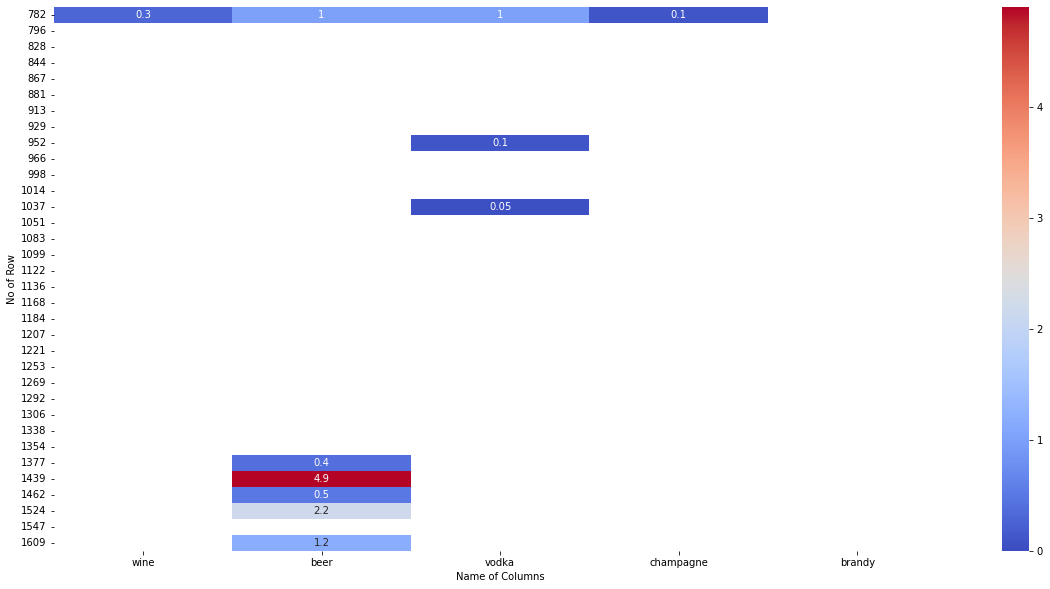

In [219]:
key = df_10["brandy"].isnull()
df_na = df_10.loc[key]
df_notna = df_10.loc[~key]
df_na
plt.subplots(figsize=(20,10))
sns.heatmap(df_na[category],vmin=0,annot=True,cmap="coolwarm")
plt.ylabel('No of Row')
plt.xlabel('Name of Columns')
df_10=df.dropna(subset=['brandy'])

Based on the number of blank data in the brandy column, the row that accompanies the brandy column will be deleted. Because of the row that accompanies the empty value, many of the brandy columns have empty values as well. In addition, because the empty value in the brandy column is less than 5%, it will not affect the quality of the dataset. 
In addition, the number of empty values in each column will also be displayed after the empty values in the brandy column are deleted

In this step, data visualization will be carried out regarding the distribution of data using a distribution plot. This visualization is to find out the distribution of data from each column or variable. This is to find out how the data from each column is distributed for each value. And also to tell whether this data can follow a normal distribution or not. 

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distribut

Text(0.5, 1.0, 'brandy')

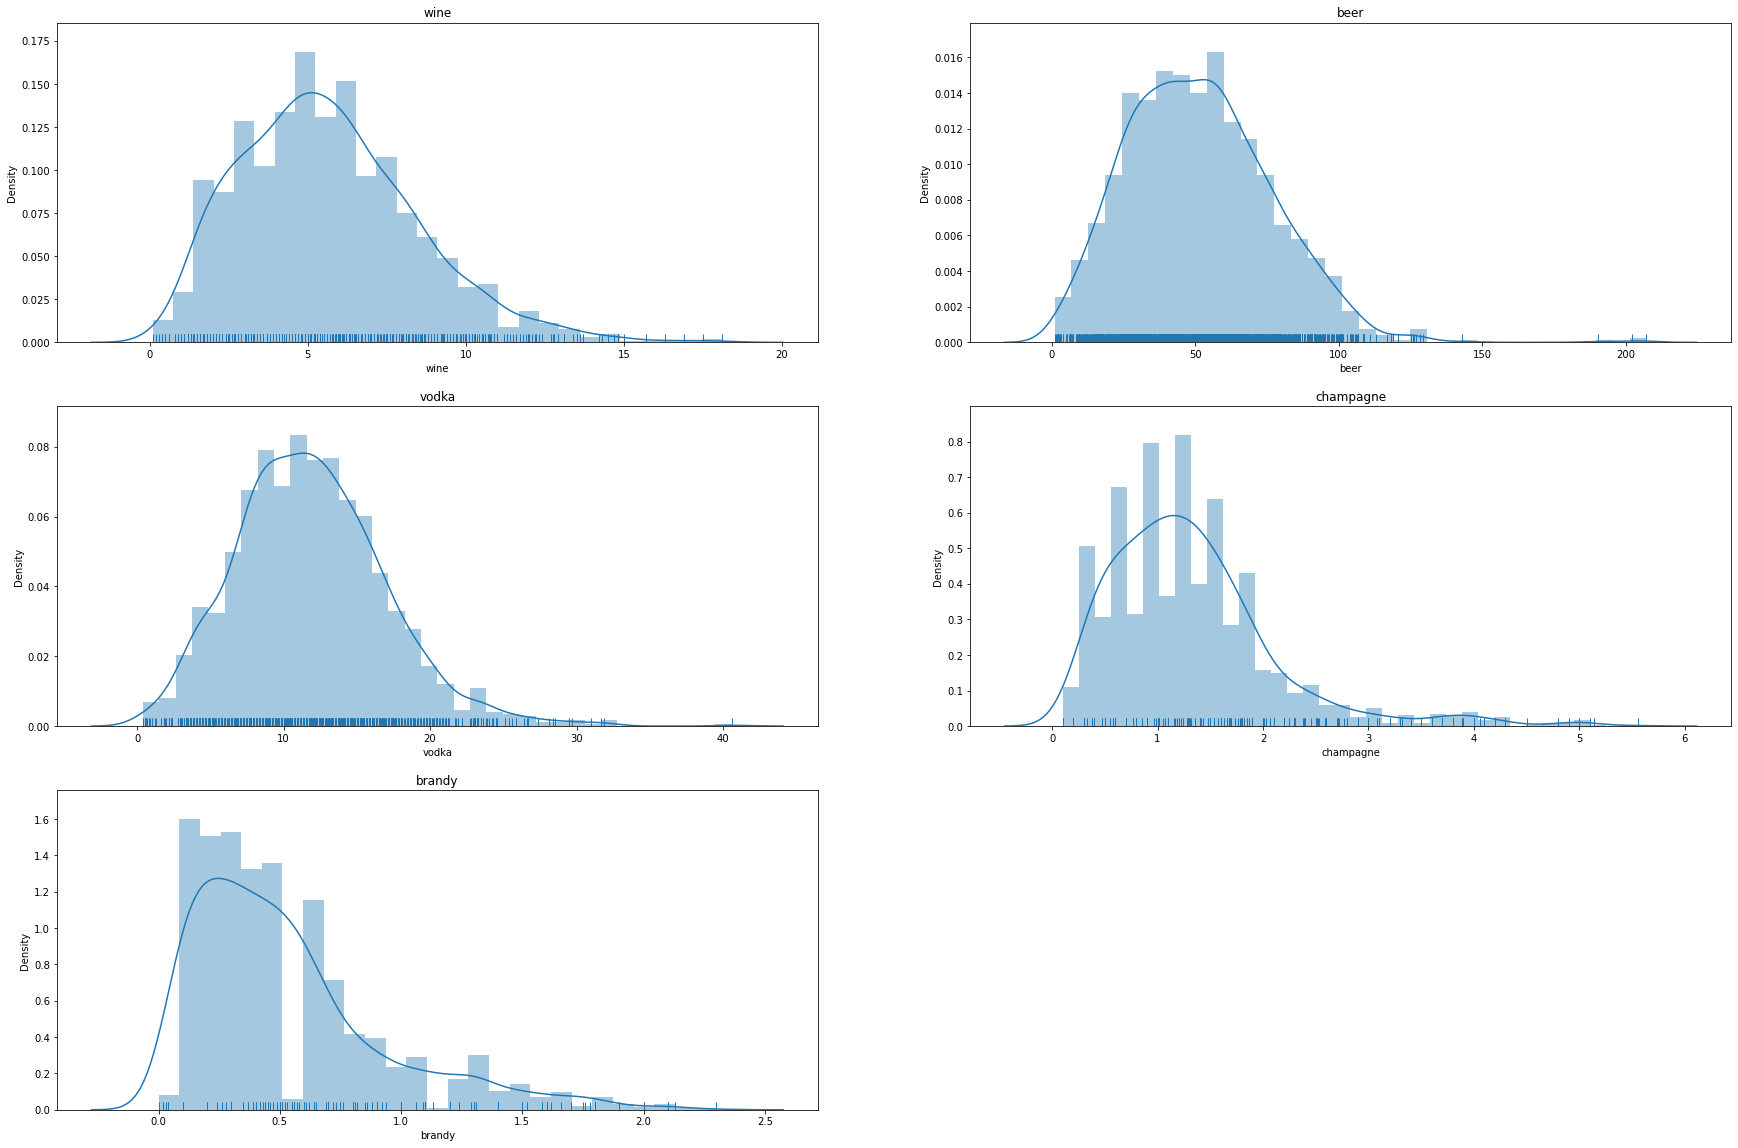

In [220]:
plt.subplots(figsize=(30,20))
fig=plt.subplot(3,2,1)
sns.distplot(df_10['wine'],rug=True )
plt.title('wine')
fig=plt.subplot(3,2,2)
sns.distplot(df_10['beer'], rug=True)
plt.title('beer')
fig=plt.subplot(3,2,3)
sns.distplot(df_10['vodka'], rug=True)
plt.title('vodka')
fig=plt.subplot(3,2,4)
sns.distplot(df_10['champagne'], rug=True)
plt.title('champagne')
fig=plt.subplot(3,2,5)
sns.distplot(df_10['brandy'], rug=True)
plt.title('brandy')

In addition to visualizing the distribution of plots, data visualization will be carried out using boxplots. This boxplot is useful for knowing the distribution of data by showing the outlier values of each column and will also calculate the number of outliers from each column as well. In order to make it easier to find out the amount of outlier data, a calculation will be carried out to find out the number of outlier data. In addition, the interquartile value (IQR) will also be presented to find out how big the distribution of data from each column/variable is. The greater the distribution of the data, it can be said that the data is more spread out in the dataset

Text(0.5, 1.0, 'brandy')

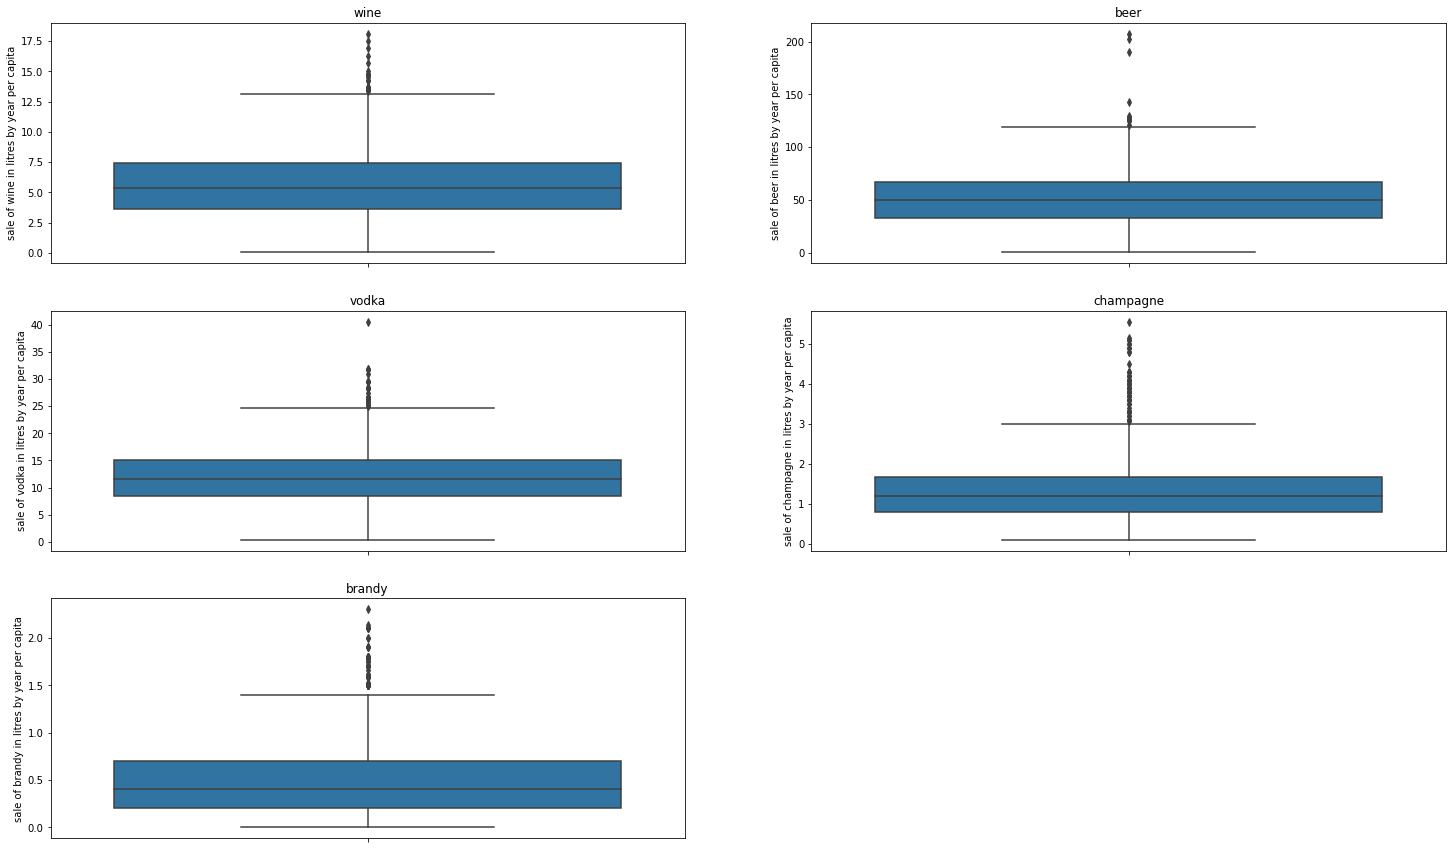

In [221]:
plt.subplots(figsize=(25,15))
fig=plt.subplot(3,2,1)
sns.boxplot(data=df_10,y='wine')
plt.ylabel('sale of wine in litres by year per capita')
plt.title('wine')
fig=plt.subplot(3,2,2)
sns.boxplot(data=df_10,y='beer')
plt.ylabel('sale of beer in litres by year per capita')
plt.title('beer')
fig=plt.subplot(3,2,3)
sns.boxplot(data=df_10,y='vodka')
plt.ylabel('sale of vodka in litres by year per capita')
plt.title('vodka')
fig=plt.subplot(3,2,4)
sns.boxplot(data=df_10,y='champagne')
plt.ylabel('sale of champagne in litres by year per capita')
plt.title('champagne')
fig=plt.subplot(3,2,5)
sns.boxplot(data=df_10,y='brandy')
plt.ylabel('sale of brandy in litres by year per capita')
plt.title('brandy')

Outlier data is extreme data that is out of range with most of the values in its group. where this data needs to be considered and given special treatment to minimize bias in research. Upperbound value is obtained from the calculation of 1.5 * IQR. This upper bound is the upper limit for separating extreme data.

In [222]:
def outliers(data):
    q3,q1=np.percentile(df_10[data],[75,25])
    iqr = round(q3-q1,2)
    upperbound = round((q3+1.5*iqr),2)
    lowerbound = round((q1-1.5*iqr),2)
    if lowerbound <1:
        lowerbound=0
    lup=len(df_10[df_10[data] > upperbound])
    print(data," have {} upper outliers with upperbound is {},lowerbound is {},and IQR is {}.".format(lup,upperbound,lowerbound,iqr))
    return lup,upperbound
for i in category:
    outliers(i)

wine  have 19 upper outliers with upperbound is 13.1,lowerbound is 0,and IQR is 3.8.
beer  have 12 upper outliers with upperbound is 119.85,lowerbound is 0,and IQR is 34.9.
vodka  have 23 upper outliers with upperbound is 24.9,lowerbound is 0,and IQR is 6.6.
champagne  have 61 upper outliers with upperbound is 3.0,lowerbound is 0,and IQR is 0.88.
brandy  have 65 upper outliers with upperbound is 1.45,lowerbound is 0,and IQR is 0.5.


- Based on the figure that has been presented previously, it can be seen that the distribution of each column shows that all the columns from dataset have a right skew pattern.
- Next, a boxplot will be carried out to find out more about the description of the distribution of data from each column. In this boxplot will be shown how many outlier values (extreme) from each column.

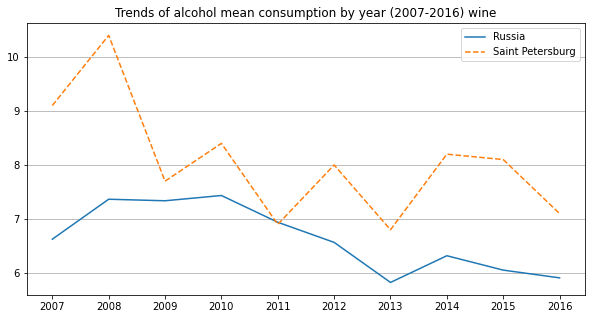

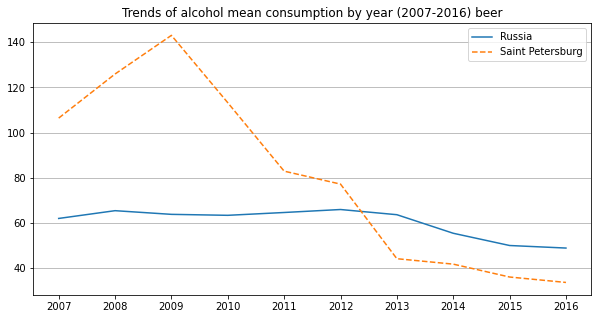

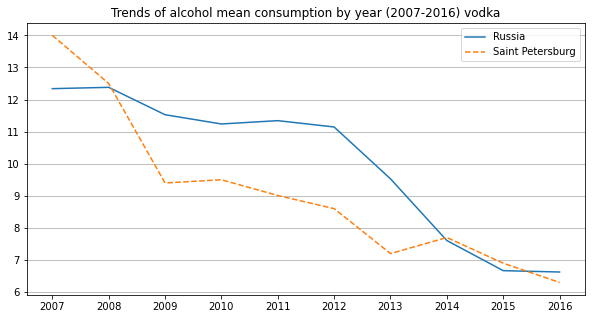

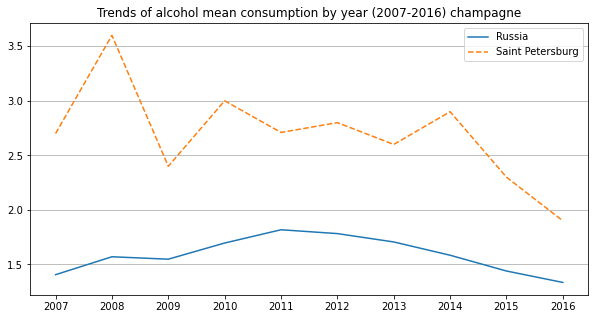

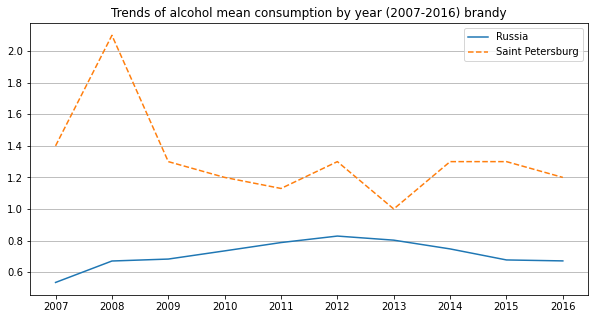

In [265]:
#Avaerage of Russia's alcohol consumption yearly
df_avg_by_year = pd.DataFrame(df_10.groupby("year").agg('mean')).reset_index()
#seperate spesific region (Saint petersburg)
df_petersburg = df_10.query("region == 'Saint Petersburg'")

for i in category:
    fig = plt.subplots(figsize=(10,5))
    fig = sns.lineplot(x = "year", y = i, data = df_avg_by_year)
    fig = sns.lineplot(x = "year", y = i, data = df_petersburg, linestyle="--")
    fig.legend(["Russia","Saint Petersburg"])
    fig.set(title=("Trends of alcohol mean consumption by year (2007-2016) {}".format(i)),xlabel = "", ylabel="")
    plt.grid(axis='y')
    plt.show

Based on 5 figures shown before, we san see that mean of brandy, champagne, and wine from St. Petersburg has a higher average when compared to the average consumption of the entire region of Russia. For beer and vodka at the end of the year the dataset has a lower average consumption than the regional average for the whole of Russia. Overall, the average consumption of each liquor tends to decrease from year to year.

In [266]:
# Summarizing summary by five types of alcohol by region
df_by_region = df_10.groupby('region')["wine", "beer", "vodka", "champagne", "brandy"].mean()
df_by_region_1 = df_by_region.reset_index().drop(columns = 'region')

# Standarization data
standard = StandardScaler()
df_by_region_standard = standard.fit_transform(df_by_region_1)
df_by_region_standard = pd.DataFrame(df_by_region_standard,columns = df_by_region.columns,index = df_by_region.index)
df_by_region_standard.isna().sum()
df_by_region_standard = df_by_region_standard.dropna()


C:\Users\ASUS\AppData\Local\Temp/ipykernel_14808/2706281395.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_by_region = df_10.groupby('region')["wine", "beer", "vodka", "champagne", "brandy"].mean()


The next step I will do clustering process to get a grouping of datasets that have similarities. I will use the clustering process with the kmeans method. In order to find out the optimal number of clusters, a plot using the elbow method will be carried out in the process below. the distance used is in the range of 2 and 9.

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows wi

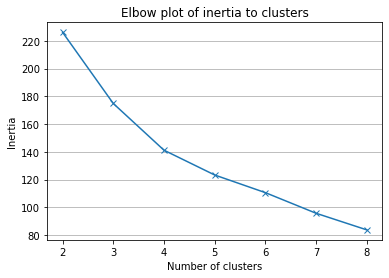

In [269]:
cluster_num = np.arange(2,9) 
inertia_list = []

for num in cluster_num:
    kmeans = KMeans(n_clusters = num, algorithm="full").fit(df_by_region_standard)
    inertia_list.append(kmeans.inertia_)

# Plotting the inertia as a function of the number of clusters
plt.plot(cluster_num, inertia_list, marker="x")
plt.title("Elbow plot of inertia to clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid(axis="y")
plt.show()

Based on the plot above, there is no elbow pattern so it cannot be determined the number of clusters that will be used. For this reason, the next process will be carried out, namely using PCA to reduce variables that affect clustering

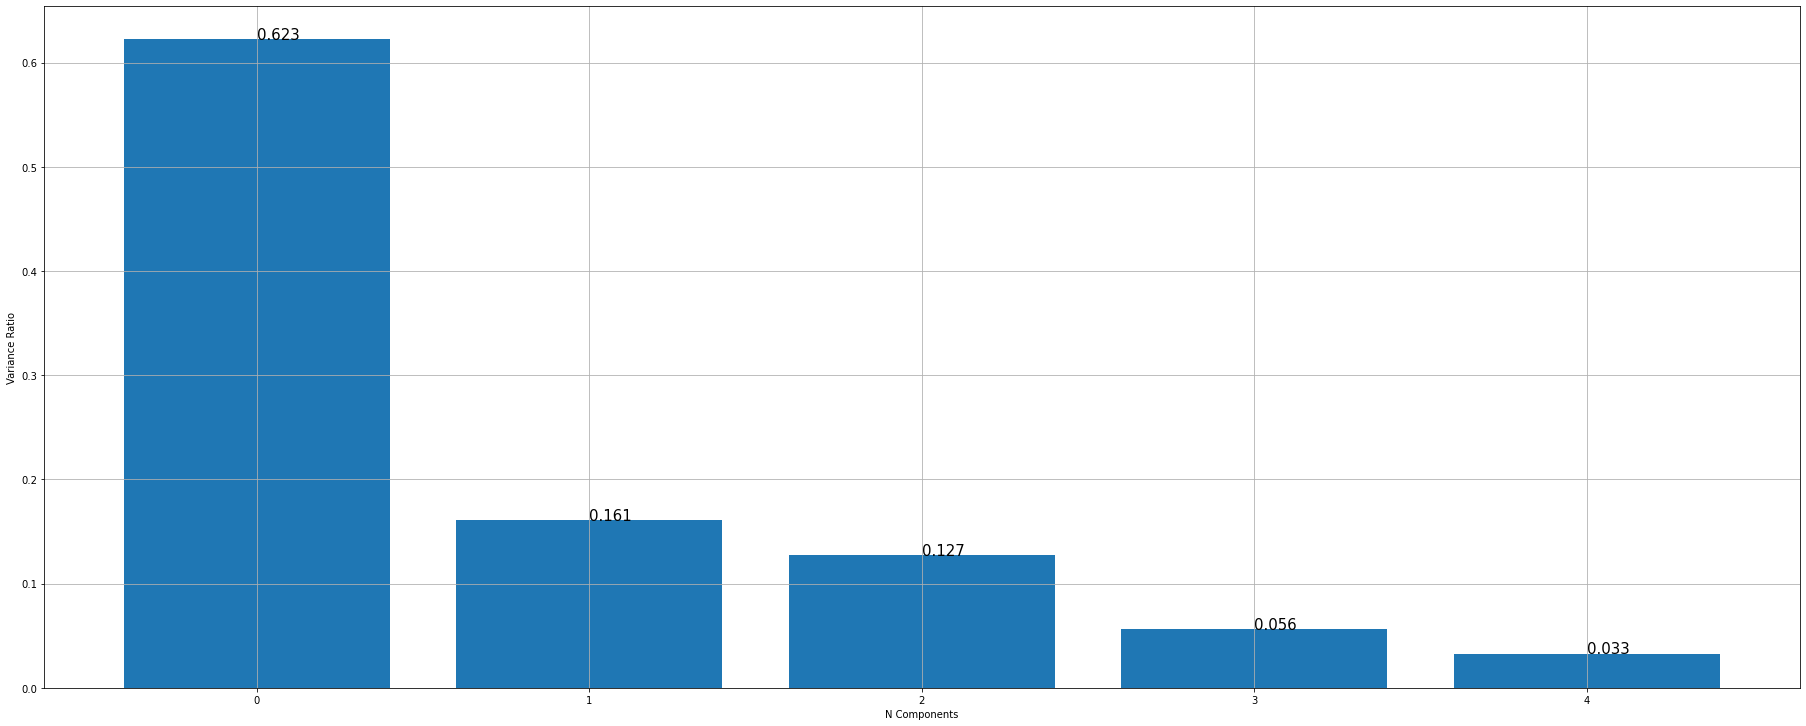

In [213]:
pca = PCA()
pca_array = pca.fit_transform(df_by_region_standard)
pca_1 = pd.DataFrame(pca.explained_variance_ratio_).rename(columns = {0:'Variance_ratio'})
pca_1['pareto'] = 100*pca_1.Variance_ratio.cumsum() / pca_1.Variance_ratio.sum()
slicing15 = pca_1[:15]
slicing15.Variance_ratio = round(slicing15.Variance_ratio,3)

plt.subplots(figsize=(25,10))
plot = plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
for index,data in enumerate(slicing15['Variance_ratio']):
    plt.text(x=index , y =data,s=f"{data}", fontdict=dict(fontsize=15))
plt.tight_layout()
plt.ylabel('Variance Ratio')
plt.xlabel('N Components')
plt.grid(True)

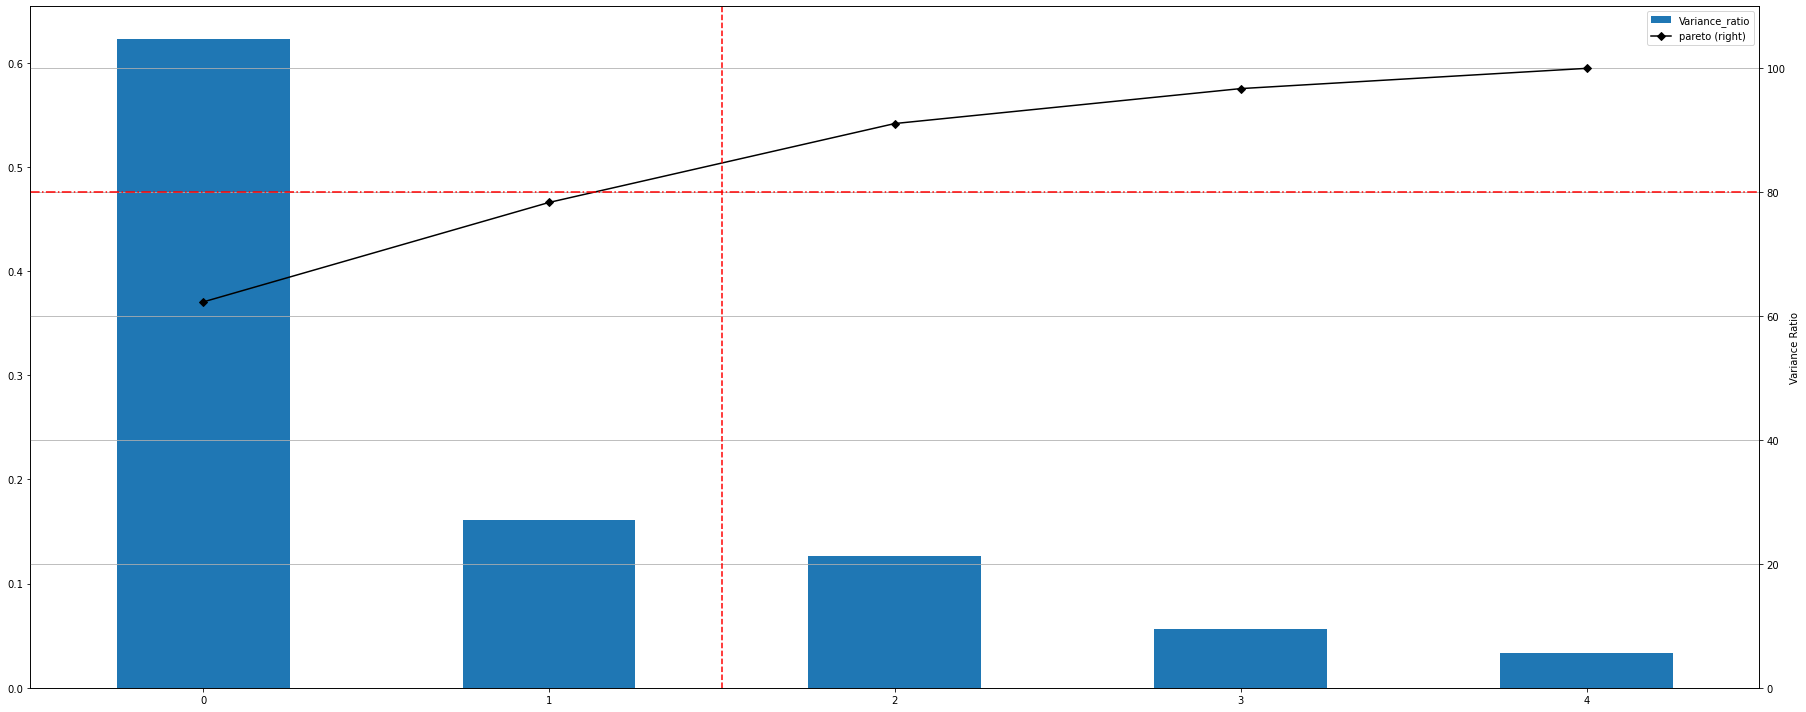

In [214]:
fig,axes = plt.subplots(figsize=(25,10))
ax1 = pca_1.plot(y='Variance_ratio', use_index=True, kind='bar', ax=axes )
ax2 = pca_1.plot(y='pareto', use_index=True, kind='line',color='black', marker='D', secondary_y=True, ax=axes)
plt.tight_layout()
plt.axvline(x=1.5, color = "red", linestyle="--")
plt.axhline(y=80, color = "red", linestyle="dashdot")
plt.ylabel('Variance Ratio')
plt.xlabel('N Components')
ax2.set_ylim([0,110])
plt.grid(True)
plt.show()

Based on the picture above, the selection of features is limited to a few variance ration features. The specified limit is 80%, where 80% of this value has represented the problems or features that exist in this study.

In [152]:
df_pca = pd.DataFrame({f"Feature_{i+1}": pca_array[:, i] for i in range(2)}, index=df_by_region_standard.index)
df_pca

,Feature_1,Feature_2
region,,
Altai Krai,-1.572699,-0.123161
Altai Republic,-1.309498,-0.024887
Amur Oblast,-0.022819,-0.558930
Arkhangelsk Oblast,1.854417,0.883990
Astrakhan Oblast,-1.195280,-0.552522
...,...,...
Vologda Oblast,0.891382,-1.236732
Voronezh Oblast,-0.288047,-0.582721
Yamalo-Nenets Autonomous Okrug,1.904643,-0.544029


Next, a scatter plot will be created based on the specified range (ie 2 to 9). Where each distance will represent how many clusters will be determined. for example, k=3 means that there are 3 clusters formed on the scatter plot.

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows wi

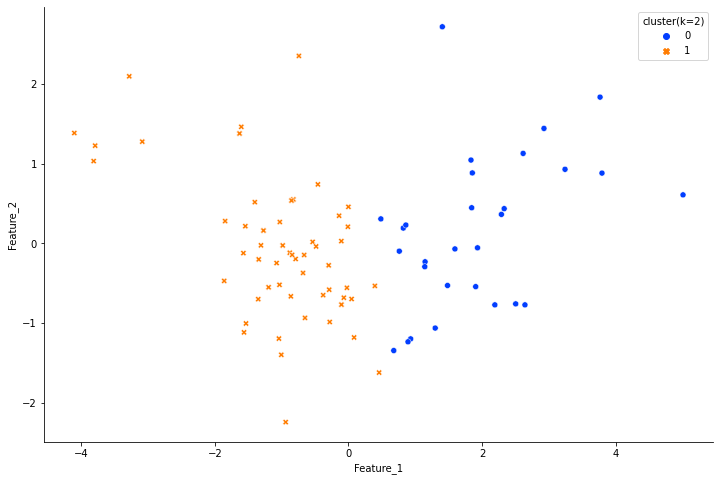

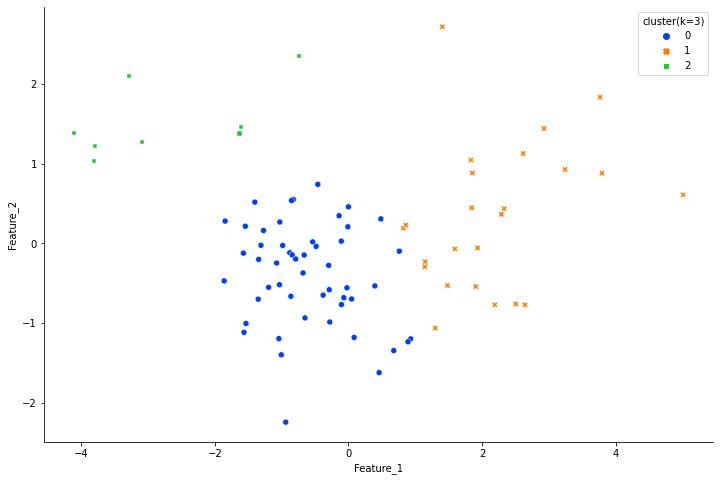

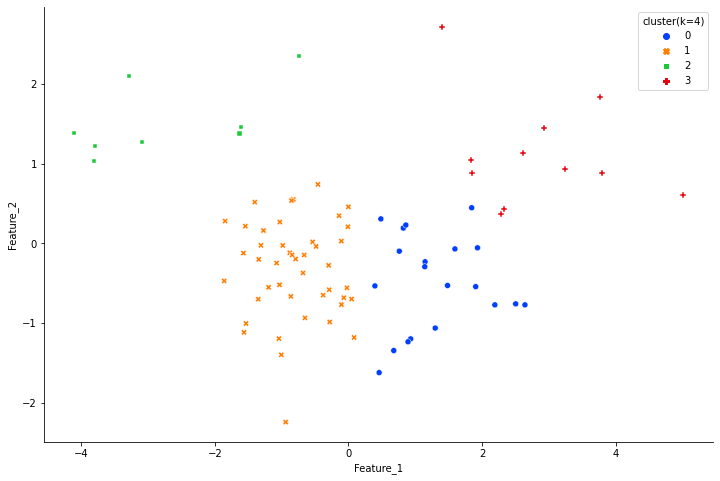

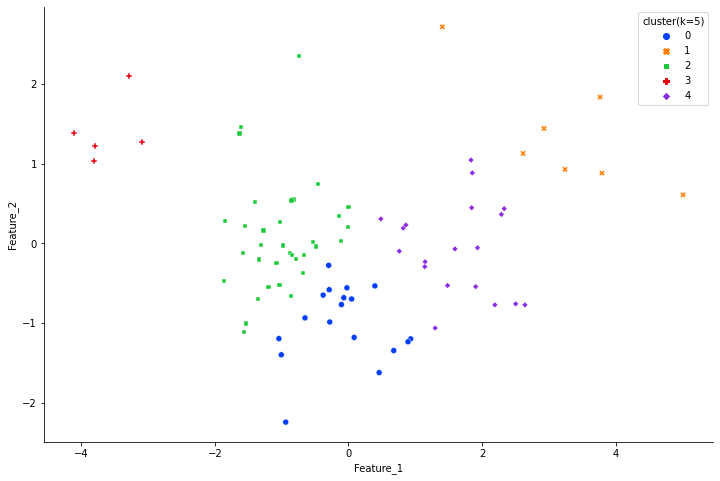

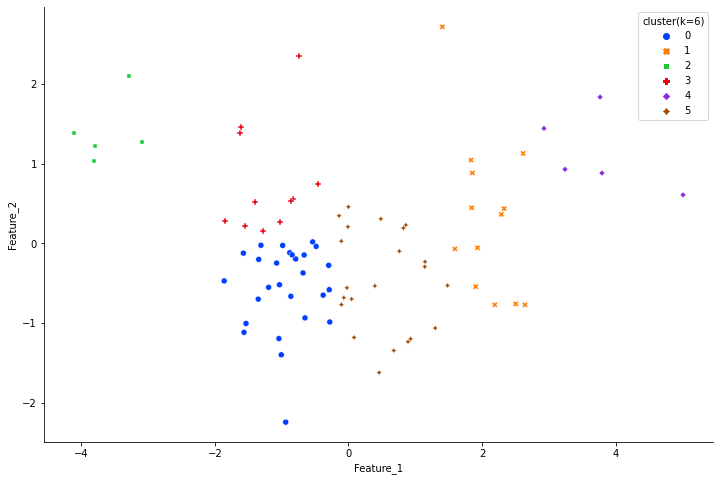

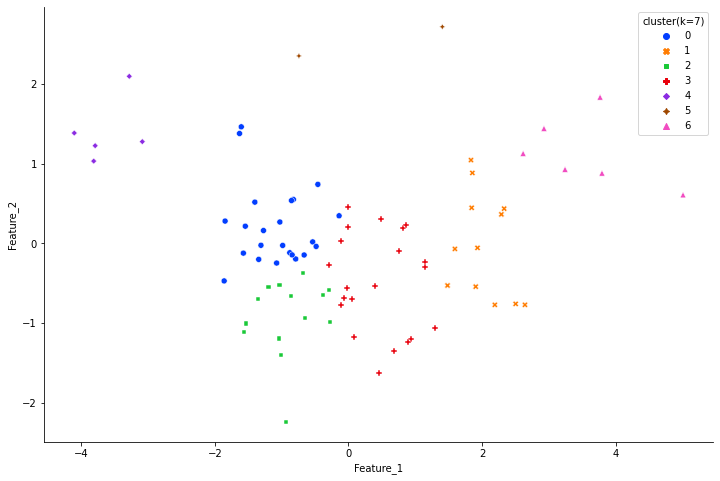

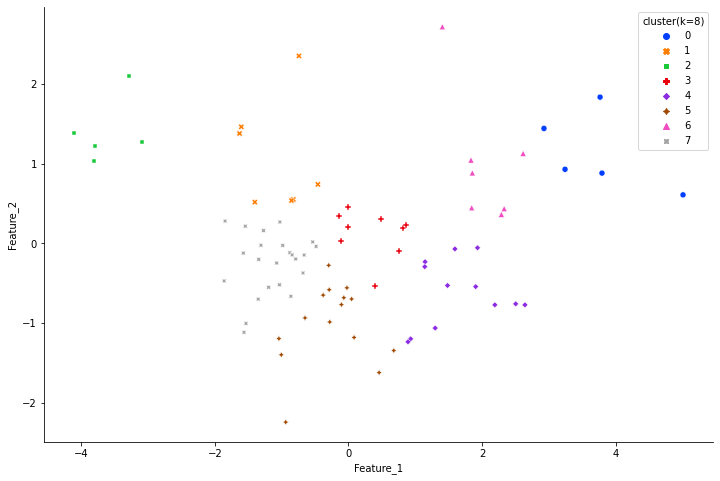

In [153]:
for i in cluster_num:
    plt.subplots(figsize=(12,8))
    kmeans = KMeans(n_clusters = i, random_state = 1,algorithm='full')
    kmeans.fit(df_pca)
    pca_df_k_dummy = df_pca.copy()
    pca_df_k_dummy[f"cluster(k={i})"] = kmeans.labels_
    sns.scatterplot(x="Feature_1",y="Feature_2",data=pca_df_k_dummy,hue=f"cluster(k={i})",style=f"cluster(k={i})",palette='bright')
    sns.despine()

In this study, I will determine the number of clusters as many as 4 clusters. Because from my observations, in a cluster containing 4 groups, the number in each cluster is almost the same. In addition, the division on the x-axis of these 4 clusters tends to be balanced

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


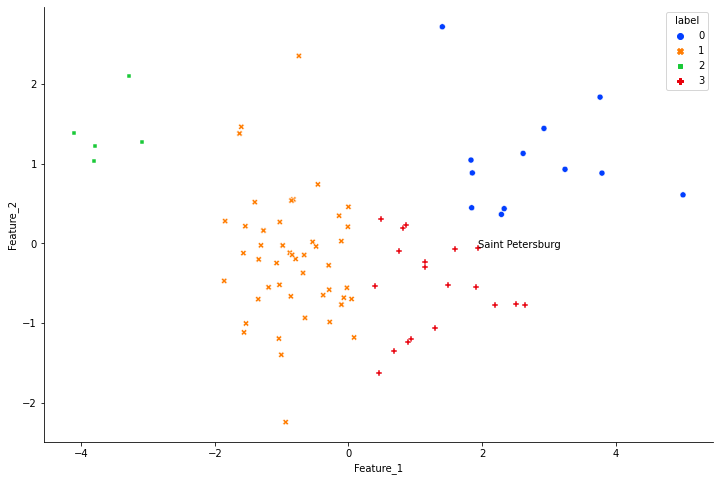

(array([1.93183137]), array([-0.05659183]))

In [270]:
kmeans4=KMeans(n_clusters=4, random_state = 1,algorithm='full')
kmeans4.fit(df_pca)
df_pca["label"] = kmeans4.labels_

plt.subplots(figsize=(12,8))
sns.scatterplot(x = 'Feature_1',y = 'Feature_2',data = df_pca, hue = 'label', style = 'label',palette = 'bright')
sns.despine()
st_peter_x = df_pca.query("region == 'Saint Petersburg'").Feature_1.values
st_peter_y = df_pca.query("region == 'Saint Petersburg'").Feature_2.values
plt.annotate("Saint Petersburg", xy = (st_peter_x, st_peter_y), xytext=(st_peter_x, st_peter_y))
plt.show()
st_peter_x,st_peter_y

- The following is an illustration of a scatter plot of 4 clusters. Where can also be seen that st petersburg is in cluster 3
- To be able to find out the 10 recommended regions for promotion, I will use distance measurements using the Euclidian method. Where the shorter the distance from St Petersburg, the closer it is to St Petersburg

In [193]:
listofdistance=[]
for x, y in zip(df_pca.Feature_1, df_pca.Feature_2):
    distance = ((x-st_peter_x)**2 + (y-st_peter_y)**2)**0.5
    listofdistance.append(distance)
df_pca['Distance_from_St_Petersburg']=np.array(listofdistance)
df_top10 = df_pca.sort_values('Distance_from_St_Petersburg').head(11)
df_top10

,Feature_1,Feature_2,label,Distance_from_St_Petersburg
region,,,,
Saint Petersburg,1.931831,-0.056592,2,0.000000
Khanty–Mansi Autonomous Okrug – Yugra,1.593702,-0.070502,2,0.338415
Yamalo-Nenets Autonomous Okrug,1.904643,-0.544029,2,0.488195
Novgorod Oblast,1.844243,0.446433,0,0.510593
Republic of Karelia,2.289298,0.363269,0,0.551421
Leningrad Oblast,2.330753,0.435317,0,0.633334
Tyumen Oblast,1.482940,-0.529580,2,0.652090
Khabarovsk Krai,2.191358,-0.772864,2,0.761840
Tver Oblast,1.146957,-0.231814,2,0.804196


1     Khanty–Mansi Autonomous Okrug – Yugra
2            Yamalo-Nenets Autonomous Okrug
3                           Novgorod Oblast
4                       Republic of Karelia
5                          Leningrad Oblast
6                             Tyumen Oblast
7                           Khabarovsk Krai
8                               Tver Oblast
9                          Yaroslavl Oblast
10                            Moscow Oblast
Name: region, dtype: object

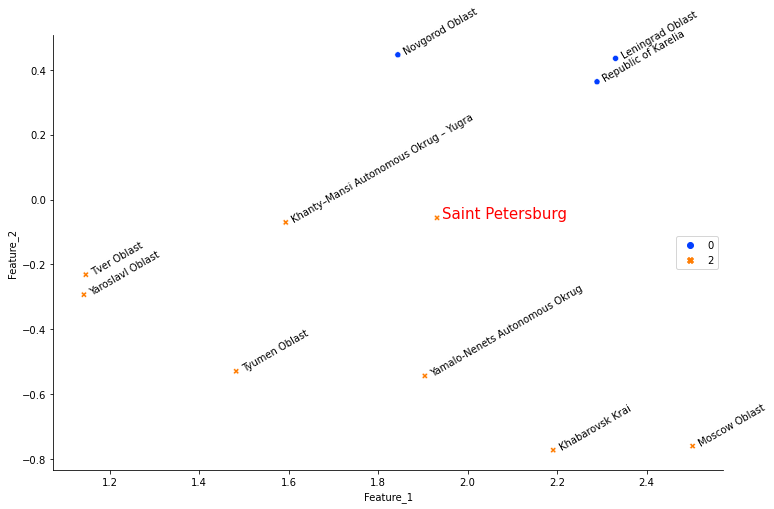

In [194]:
plt.subplots(figsize=(12,8))
sns.scatterplot(x='Feature_1',y='Feature_2',data=df_top10,hue = 'label',style = 'label',palette = 'bright',)
sns.despine()
cek=df_top10.reset_index()
plt.legend(loc="center right")
display(cek.region[1:11])
for region, x, y in zip(df_top10.index, df_top10.Feature_1, df_top10.Feature_2):
    if region=='Saint Petersburg':
        plt.text(x+.01, y, region, fontsize = 15,c='red')
    else:
        plt.text(x+.01, y, region, fontsize = 10,rotation = 30)

The following are 10 cities that have similar alcohol consumption similarities to St Petersburg. These 10 cities are shown in the table where the top one is very similar to St. Petersburg because of its proximity to St. Petersburg. And also presented a scatterplot to 10 cities similar to St Petersburg